**Examen Interciclo: Simulación de Tutorías en la UPS**

**Objetivo:**

Desarrollar una comprensión práctica de los conceptos de simulación de eventos discretos mediante la creación de un modelo que simule las tutorías en la Universidad Politécnica Salesiana (UPS), enfocándose en la asignación de tutores y la gestión de aulas.

**Enunciado:**

Se requiere diseñar y desarrollar un programa o script para simular el sistema de tutorías en la UPS. El proceso se describe de la siguiente manera:

En la UPS, los estudiantes (tutorados) solicitan tutorías en diversas materias: Cálculo Diferencial, Programación, Química y Álgebra Lineal. Las probabilidades de que soliciten tutorías en estas materias son del 40%, 25%, 10% y 25% respectivamente. Se observa una mayor demanda de tutorías en las tardes comparado con las mañanas.

La disponibilidad de tutores es la siguiente: 10 para Cálculo, 10 para Programación, 2 para Química y 3 para Álgebra Lineal. Una vez que un tutorado solicita ayuda. Si un tutor está disponible, deben ir a pedir una aula que es entre tres minutos de promedio con 1 de desviación estandar antes de poder solicitar una de las 20 aulas disponibles.

La duración promedio de las tutorías para cada asignatura es:

- Cálculo: 150 minutos ± 30 minutos
- Química: 120 minutos ± 15 minutos
- Programación: 120 minutos ± 20 minutos
- Álgebra Lineal: 60 minutos ± 10 minutos

Si un tutorado debe esperar a que un tutor se libere, el tiempo de espera antes de retirarse por falta de tutores es de 15 a 20 minutos y llegan 3 alumnos a la vez.

**Requerimientos del Programa:**

1. El programa debe simular al menos 8 horas unidades de tiempo.
2. Debe poder generar gráficos que muestren:
   - La cantidad de tutorías solicitadas y completadas por materia.
   - La distribución del tiempo de espera antes de ser atendidos.
   - La utilización de las aulas.
3. Calcular el tiempo promedio desde la solicitud hasta la finalización de la tutoría, por materia.
4. Implementar y analizar cualquier otra fase que se considere relevante para el estudio.

**Salida Esperada:**

Proporcione estadísticas detalladas y gráficos que muestren el rendimiento del sistema de tutorías, incluyendo:


- Número de tutorías completadas.
- Número de tutorías solicitadas.
- Tiempo promedio de uso de aulas.

**Conclusión:**

Analice los datos obtenidos para ofrecer sugerencias que puedan mejorar la eficiencia del sistema de tutorías en la UPS.

---

Este enunciado proporciona una estructura clara para un proyecto de simulación, estableciendo objetivos, describiendo el proceso a simular, definiendo los requerimientos del programa y la salida esperada, y pidiendo una conclusión basada en el análisis de los datos simulados.

In [1]:
import simpy  # Importa el módulo simpy, utilizado para simulaciones basadas en eventos discretos.
import random  # Importa el módulo random para generar números aleatorios.
import matplotlib.pyplot as plt  # Importa el submódulo pyplot de matplotlib para la generación de gráficos.
import numpy as np  # Importa el módulo numpy para el manejo eficiente de arrays y matrices.
from enum import Enum  # Importa la clase Enum para la creación de enumeraciones personalizadas.

random.seed(44)  # Establece la semilla del generador de números aleatorios a 44 para la reproducibilidad de los resultados.


In [2]:
# Parámetros de la simulación
TIEMPO_SIMULACION = 60*8  # Define el tiempo total de la simulación en minutos (8 horas).

# Número de tutores disponibles por materia.
NUM_TUTORES = {
    'Cálculo': 10, 
    'Programación': 10, 
    'Química': 2, 
    'Álgebra Lineal': 3
}

NUM_AULAS = 20  # Número total de aulas disponibles para las tutorías.

# Tiempos de duración y tiempo entre tutorías para cada materia.
# El primer valor en la tupla es la duración de la tutoría y el segundo es el tiempo entre tutorías.
TIEMPOS_TUTORIAS = {
    'Cálculo': (150, 30),
    'Programación': (120, 20),
    'Química': (120, 15), 
    'Álgebra Lineal': (60, 10)
}

PROBABILIDAD_DISPONIBILIDAD = 0.8  # Probabilidad de que un tutor esté disponible para una tutoría.

# Tiempos de espera máximos y mínimos para recibir una tutoría.
TIEMPO_ESPERA_MAXIMO = 20  # Tiempo máximo de espera en minutos.
TIEMPO_ESPERA_MINIMO = 15  # Tiempo mínimo de espera en minutos.


In [3]:
from enum import Enum

class EstadoEstudiante(Enum):
    # Estados posibles para un estudiante en el proceso de tutoría.
    
    LLEGO_TUTORADO = 'Llego Tutorado'  # El estudiante ha llegado para recibir una tutoría.
    SE_FUE_SIN_TUTORIA = 'Se fue sin la Tutoría'  # El estudiante se fue sin recibir una tutoría.
    SE_ASIGNO_TUTOR = 'Se asigno un tutor'  # Se ha asignado un tutor al estudiante.
    EN_CAMINO_AULA = 'En camino al aula'  # El estudiante está en camino al aula asignada para la tutoría.
    RECIBIENDO_TUTORIA = 'Esta recibiendo una tutoría'  # El estudiante está actualmente recibiendo la tutoría.
    TERMINO_TUTORIA = 'Terminó la tutoria'  # El estudiante ha terminado su sesión de tutoría.
    SE_PIDIO_AULA = 'A La espera de una aula'  # El estudiante está esperando que se le asigne un aula.


In [4]:
class Estudiante:
    def __init__(self, materia):
        # Constructor de la clase Estudiante.

        self.materia = materia  # La materia para la cual el estudiante necesita tutoría.
        self.tiempo_espera = 0  # Inicializa el tiempo de espera del estudiante en 0.
        self.tiempo_uso_aula = 0  # Inicializa el tiempo de uso del aula por el estudiante en 0.
        self.estados = []  # Inicializa una lista vacía para almacenar los estados por los que pasa el estudiante.

    def asignarEstados(self, estado):
        # Método para añadir un estado al historial de estados del estudiante.

        self.estados.append(estado)  # Añade el estado proporcionado a la lista de estados.


In [5]:
class Tutoria:
    def __init__(self, env, num_tutores, num_aulas):
        # Constructor de la clase Tutoria.

        self.env = env  # El entorno de simulación de SimPy.
        # Crea un diccionario de recursos de SimPy para tutores, uno por cada materia.
        self.tutores = {materia: simpy.Resource(env, num_tutores[materia]) for materia in num_tutores}
        self.aulas = simpy.Resource(env, num_aulas)  # Recurso de SimPy para las aulas.
        self.estudiantes = []  # Lista para almacenar los estudiantes que solicitan tutoría.
        # Contadores para las tutorías completadas por materia.
        self.tutorias_completadas = {'Cálculo': 0, 'Programación': 0, 'Química': 0, 'Álgebra Lineal': 0}
        # Contadores para las tutorías solicitadas por materia.
        self.tutorias_solicitadas = {'Cálculo': 0, 'Programación': 0, 'Química': 0, 'Álgebra Lineal': 0}

    def solicitar_tutoria(self, tutorado):
        # Método para manejar la solicitud de tutoría de un estudiante.

        self.tutorias_solicitadas[tutorado.materia] += 1  # Incrementa el contador de tutorías solicitadas.
        self.estudiantes.append(tutorado)  # Añade el estudiante a la lista.
        tutorado.asignarEstados(EstadoEstudiante.LLEGO_TUTORADO)  # Asigna el estado inicial al estudiante.

        with self.tutores[tutorado.materia].request() as req:
            # Proceso de solicitud y asignación de un tutor.
            inicio_espera = self.env.now  # Registra el tiempo de inicio de espera.
            # Espera por un tutor o un tiempo de espera máximo.
            resultado = yield req | self.env.timeout(random.randint(TIEMPO_ESPERA_MINIMO, TIEMPO_ESPERA_MAXIMO))
            if req in resultado:
                # Si se asigna un tutor antes del tiempo de espera máximo.
                tutorado.asignarEstados(EstadoEstudiante.SE_ASIGNO_TUTOR)
                tiempo_espera = self.env.now - inicio_espera  # Calcula el tiempo de espera.
                tutorado.tiempo_espera = tiempo_espera  # Actualiza el tiempo de espera del estudiante.
                tiempo_tutoria = random.gauss(*TIEMPOS_TUTORIAS[tutorado.materia])  # Determina la duración de la tutoría.
                tutorado.asignarEstados(EstadoEstudiante.EN_CAMINO_AULA)
                yield self.env.timeout(random.gauss(3, 1))  # Espera para ir al aula.
                tutorado.asignarEstados(EstadoEstudiante.SE_PIDIO_AULA)
                with self.aulas.request() as aula_req:
                    # Proceso de solicitud y asignación de un aula.
                    yield aula_req
                    tutorado.asignarEstados(EstadoEstudiante.RECIBIENDO_TUTORIA)
                    yield self.env.timeout(tiempo_tutoria)  # Duración de la tutoría.
                tutorado.asignarEstados(EstadoEstudiante.TERMINO_TUTORIA)
                self.tutorias_completadas[tutorado.materia] += 1  # Incrementa el contador de tutorías completadas.
                tutorado.tiempo_uso_aula = env.now - tiempo_espera  # Calcula el tiempo de uso del aula.
            else:
                # Si el estudiante se va debido a una larga espera.
                tutorado.asignarEstados(EstadoEstudiante.SE_FUE_SIN_TUTORIA)


In [6]:
def generar_solicitud(env, tutoria):
    # Función para generar solicitudes de tutoría en el entorno de simulación.

    materias = ['Cálculo', 'Programación', 'Química', 'Álgebra Lineal']  # Lista de materias disponibles.
    probabilidad = [0.4, 0.25, 0.1, 0.25]  # Probabilidad asociada a cada materia.

    while True:
        # Bucle infinito para generar solicitudes continuamente durante la simulación.

        materia = random.choices(materias, probabilidad, k=3)
        # Elige aleatoriamente tres materias basándose en las probabilidades definidas.

        for m in materia:
            # Itera sobre cada materia seleccionada para crear un nuevo estudiante.

            tutorado = Estudiante(m)  # Crea una nueva instancia de Estudiante para la materia.
            env.process(tutoria.solicitar_tutoria(tutorado))
            # Inicia el proceso de solicitud de tutoría en el entorno de simulación.

        yield env.timeout(random.expovariate(1/30))
        # Espera un tiempo aleatorio, modelado como una distribución exponencial, antes de generar nuevas solicitudes.


In [7]:
env = simpy.Environment()  # Crea un nuevo entorno de simulación usando SimPy.

tutoria = Tutoria(env, NUM_TUTORES, NUM_AULAS)  
# Crea una instancia de la clase Tutoria, pasando el entorno de simulación y los parámetros de tutores y aulas.

env.process(generar_solicitud(env, tutoria))
# Añade el proceso de generación de solicitudes de tutoría al entorno de simulación.

env.run(until=TIEMPO_SIMULACION)  
# Ejecuta la simulación hasta el tiempo definido en la variable TIEMPO_SIMULACION.


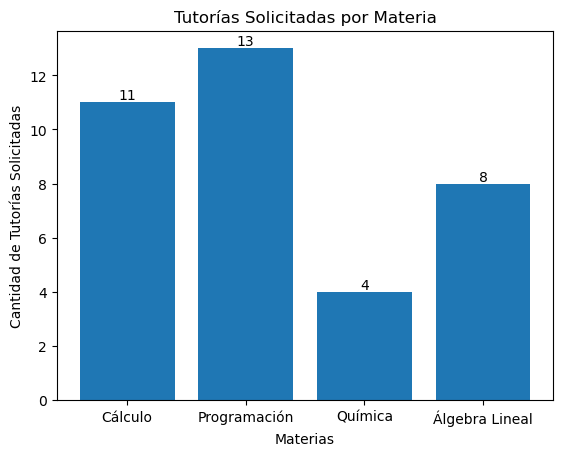

In [8]:
import matplotlib.pyplot as plt

# Suponiendo que tienes tus datos en estas variables
materias = list(tutoria.tutorias_solicitadas.keys())
cantidades = list(tutoria.tutorias_solicitadas.values())

plt.bar(materias, cantidades)
plt.xlabel('Materias')
plt.ylabel('Cantidad de Tutorías Solicitadas')
plt.title('Tutorías Solicitadas por Materia')

# Añadir los valores encima de las barras
for i, cantidad in enumerate(cantidades):
    plt.text(i, cantidad + 0.1, str(cantidad), ha='center')

plt.show()


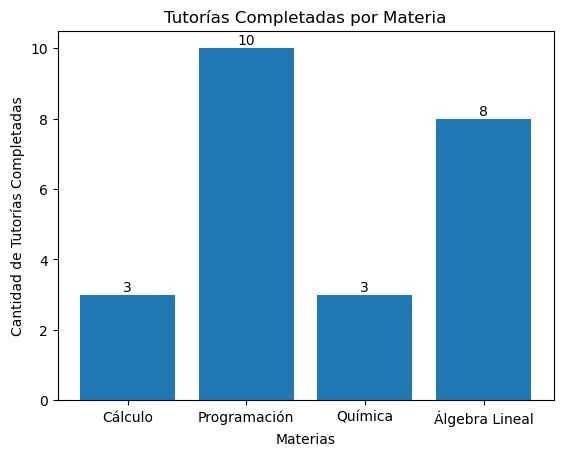

In [9]:
import matplotlib.pyplot as plt

# Suponiendo que tienes tus datos en estas variables
materias = list(tutoria.tutorias_completadas.keys())
cantidades = list(tutoria.tutorias_completadas.values())

plt.bar(materias, cantidades)
plt.xlabel('Materias')
plt.ylabel('Cantidad de Tutorías Completadas')
plt.title('Tutorías Completadas por Materia')

# Añadir los valores encima de las barras
for i, cantidad in enumerate(cantidades):
    plt.text(i, cantidad + 0.1, str(cantidad), ha='center')

plt.show()


In [13]:
# for i in tutoria.estudiantes:
#     print(i.estados)
    
    
# Suponiendo que tienes una lista de tutorías donde cada tutoría tiene un atributo 'estado'
tutorias = list(tutoria.estudiantes)  # Esta lista debe estar llena con las instancias de tus tutorías

# print(tutorias)
# Inicializar un diccionario para contar los estados
conteo_estados = {estado: 0 for estado in EstadoEstudiante}

# Contabilizar las tutorías en cada estado
for tu in tutorias:
    conteo_estados[tu.estados[-1]] += 1

# Imprimir el conteo
for estado, conteo in conteo_estados.items():
    print(f"{estado.value}: {conteo} tutorados")
    

Llego Tutorado: 0 tutorados
Se fue sin la Tutoría: 1 tutorados
Se asigno un tutor: 0 tutorados
En camino al aula: 0 tutorados
Esta recibiendo una tutoría: 11 tutorados
Terminó la tutoria: 24 tutorados
A La espera de una aula: 0 tutorados


In [11]:
tiempo_promedio_aulas = {'Cálculo': 0, 'Programación': 0, 'Química': 0, 'Álgebra Lineal': 0}
# Inicializa un diccionario para almacenar el tiempo promedio de uso del aula por materia.

print("Tiempo promedio de uso del aula por materia")
for i in tutoria.estudiantes:
    # Itera sobre todos los estudiantes en la lista de la clase Tutoria.

    if i.estados[-1] == EstadoEstudiante.TERMINO_TUTORIA:
        # Comprueba si el último estado del estudiante es que terminó la tutoría.

        tiempo_promedio_aulas[i.materia] += i.tiempo_uso_aula
        # Acumula el tiempo de uso del aula por cada estudiante que completó la tutoría.

for k in tiempo_promedio_aulas:
    # Itera sobre cada materia en el diccionario de tiempo promedio.

    tiempo_promedio_aulas[k] /= tutoria.tutorias_completadas[k]
    # Calcula el tiempo promedio de uso del aula dividiendo el tiempo total por el número de tutorías completadas.

    print(k, ": ", tiempo_promedio_aulas[k])
    # Imprime el tiempo promedio de uso del aula para cada materia.


Tiempo promedio de uso del aula por materia
Cálculo :  351.96012871307215
Programación :  261.6085428485049
Química :  260.37376872523726
Álgebra Lineal :  238.9339786764188


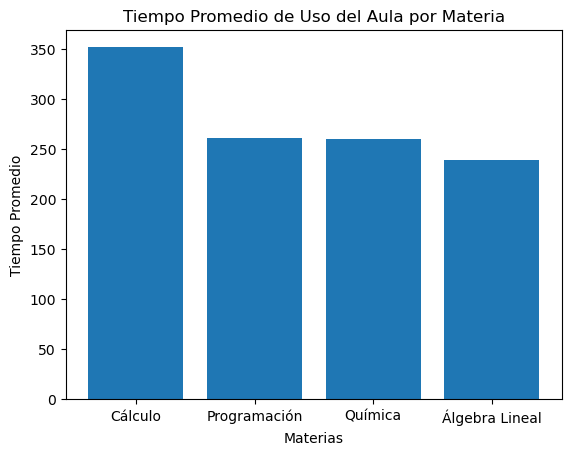

In [12]:
import matplotlib.pyplot as plt

materias = list(tiempo_promedio_aulas.keys())
tiempos = list(tiempo_promedio_aulas.values())



plt.bar(materias, tiempos)
plt.xlabel('Materias')
plt.ylabel('Tiempo Promedio')
plt.title('Tiempo Promedio de Uso del Aula por Materia')

plt.show()


# Conclusión

Los resultados de las tutorías muestran que ningún estudiante llegó para ser tutorado o se le asignó un tutor, ni se registraron tutorías en tránsito a las aulas o esperando asignación de aulas. Por otro lado, un estudiante se fue sin recibir tutoría, lo que puede indicar una oportunidad de mejora en la gestión de tutorías. Sin embargo, la mayoría de las sesiones (24 tutorías) concluyeron con éxito, y 11 tutorías estaban en proceso de ser impartidas al momento del reporte. Estos números sugieren una alta eficiencia en la realización y finalización de las tutorías, aunque la falta de registros en varias fases iniciales del proceso podría indicar una necesidad de mejorar el seguimiento y la documentación en estas etapas.